In [17]:
import pandas as pd
import numpy as np
from itertools import product
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from poker_embeddings.poker_utils.constants import RANKS_DICT
from poker_embeddings.poker_utils.model import (
    plot_train_loss,
    benchmark_dataloader)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
ev_data = pd.read_csv("../data/processed/hand_ev_processed.csv")

In [20]:
class EVDataset(Dataset):
    def __init__(self, data):
        self.card1_rank = torch.tensor(data['card1_rank_id'].values, dtype=torch.long)
        self.card2_rank = torch.tensor(data['card2_rank_id'].values, dtype=torch.long)
        self.hand_type = torch.tensor(data['hand_type_id'].values, dtype=torch.long)
        self.position_id = torch.tensor(data['position_id'].values, dtype=torch.long)
        self.players_id = torch.tensor(data['players_id'].values, dtype=torch.long)
        self.ev = torch.tensor(data['EV'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ev)

    def __getitem__(self, idx):
        return (
            self.card1_rank[idx],
            self.card2_rank[idx],
            self.hand_type[idx],
            self.position_id[idx],
            self.players_id[idx],
            self.ev[idx]
        )



In [21]:
benchmark_dataloader(EVDataset(ev_data), num_runs=5)

Dataset size: 9126 samples
Best params: batch_size=1024, num_workers=0, time 0.053


In [22]:
train_data, test_data = train_test_split(ev_data, test_size=0.2, random_state=29, stratify=ev_data[['hand']])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [23]:
train_dataset = EVDataset(train_data)
test_dataset = EVDataset(test_data)
trainloader = DataLoader(
    train_dataset,
    batch_size=1024,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

testloader = DataLoader(
    test_dataset,
    batch_size=1024,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [24]:
class cVAE(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, c_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.LeakyReLU(),
        )
        self.mean_fc = nn.Linear(hidden_dim, embedding_dim)
        self.logvar_fc = nn.Linear(hidden_dim, embedding_dim)

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim+c_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, ev, c):
        h = self.encoder(ev)
        mean = self.mean_fc(h)
        logvar = self.logvar_fc(h)
        z = self.reparameterize(mean, logvar)
        z_c = torch.cat((z, c), dim=1)
        reconstructed_x = self.decoder(z_c)
        return reconstructed_x, mean, logvar


In [25]:
def loss_func(recon_x, x, mean, logvar, beta=0.5):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return recon_loss, kl_loss, recon_loss + kl_loss*beta

In [26]:
def create_condition_vector(card1_rank, card2_rank, hand_type, position_id, players_id):
    card1_onehot = F.one_hot(card1_rank, num_classes=13)
    card2_onehot = F.one_hot(card2_rank, num_classes=13)
    handtype_onehot = F.one_hot(hand_type, num_classes=3)
    position_onehot = F.one_hot(position_id, num_classes=10)
    players_id = players_id.unsqueeze(-1).float()
    c = torch.cat((
        card1_onehot,
        card2_onehot,
        handtype_onehot,
        position_onehot,
        players_id
    ), dim=1).float()
    return c

In [27]:
def train_model(model, trainloader, testloader, optimizer, loss_func, device, beta, epochs=100):
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in trainloader:
            card1_rank, card2_rank, hand_type, position_id, players_id, ev = batch
            ev = ev.view(-1, 1).to(device)
            c = create_condition_vector(
                card1_rank,
                card2_rank,
                hand_type,
                position_id,
                players_id
            ).to(device)

            optimizer.zero_grad()
            reconstructed_x, mean, logvar = model(ev, c)
            _, _, loss = loss_func(reconstructed_x, ev, mean, logvar, beta=beta)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        model.eval()
        with torch.no_grad():
            total_test_loss = 0
            for batch in testloader:
                card1_rank, card2_rank, hand_type, position_id, players_id, ev = batch
                ev = ev.view(-1, 1).to(device)

                c = create_condition_vector(
                    card1_rank,
                    card2_rank,
                    hand_type,
                    position_id,
                    players_id
                    ).to(device)

                reconstructed_x, mean, logvar = model(ev, c)
                _, _, loss = loss_func(reconstructed_x, ev, mean, logvar, beta=beta)
                total_test_loss += loss.item()
            avg_test_loss = total_test_loss / len(testloader)
            test_losses.append(avg_test_loss)

    return train_losses, test_losses



In [28]:
hidden_dims = [4, 8, 16, 32]
embedding_dims = [2, 4, 8]
betas = [.1, .5, 1, 2, 5]
combos = product(hidden_dims, embedding_dims, betas)
results = np.empty((len(hidden_dims)*len(embedding_dims)*len(betas), 5))
epochs = 200

for i, (hidden_dim, embedding_dim, beta) in enumerate(combos):

    model = cVAE(hidden_dim=hidden_dim, embedding_dim=embedding_dim, c_dim=40)
    model = model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

    train_loss, test_loss = train_model(
        model,
        trainloader,
        testloader,
        optimizer,
        loss_func,
        device,
        beta=beta,
        epochs=epochs
        )
    print(f"Training hidden dim {hidden_dim}, embedding dim {embedding_dim}, beta {beta}")
    results[i] = np.array([hidden_dim, embedding_dim, beta, min(train_loss), min(test_loss)])
    del model
    torch.cuda.empty_cache()


Training hidden dim 4, embedding dim 2, beta 0.1
Training hidden dim 4, embedding dim 2, beta 0.5
Training hidden dim 4, embedding dim 2, beta 1
Training hidden dim 4, embedding dim 2, beta 2
Training hidden dim 4, embedding dim 2, beta 5
Training hidden dim 4, embedding dim 4, beta 0.1
Training hidden dim 4, embedding dim 4, beta 0.5
Training hidden dim 4, embedding dim 4, beta 1
Training hidden dim 4, embedding dim 4, beta 2
Training hidden dim 4, embedding dim 4, beta 5
Training hidden dim 4, embedding dim 8, beta 0.1
Training hidden dim 4, embedding dim 8, beta 0.5
Training hidden dim 4, embedding dim 8, beta 1
Training hidden dim 4, embedding dim 8, beta 2
Training hidden dim 4, embedding dim 8, beta 5
Training hidden dim 8, embedding dim 2, beta 0.1
Training hidden dim 8, embedding dim 2, beta 0.5
Training hidden dim 8, embedding dim 2, beta 1
Training hidden dim 8, embedding dim 2, beta 2
Training hidden dim 8, embedding dim 2, beta 5
Training hidden dim 8, embedding dim 4, beta

In [29]:
res_df = pd.DataFrame(results, columns=['hidden_dim', 'embedding_dim', 'beta', 'train_loss', 'test_loss'])

In [34]:
res_df.sort_values(by='test_loss', ascending=True).head()

,hidden_dim,embedding_dim,beta,train_loss,test_loss
47,32.0,2.0,1.0,2.408005,2.758404
51,32.0,4.0,0.5,2.368867,2.821969
50,32.0,4.0,0.1,2.364189,2.821970
45,32.0,2.0,0.1,2.418178,2.829463
53,32.0,4.0,2.0,2.376135,2.838518


In [35]:
model = cVAE(hidden_dim=32, embedding_dim=2, c_dim=40)
model = model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

train_loss, test_loss = train_model(
        model,
        trainloader,
        testloader,
        optimizer,
        loss_func,
        device,
        beta=1,
        epochs=200
        )

In [ ]:
# torch.save(model.state_dict(), "../model_weights/ev_vae_weights.pth")

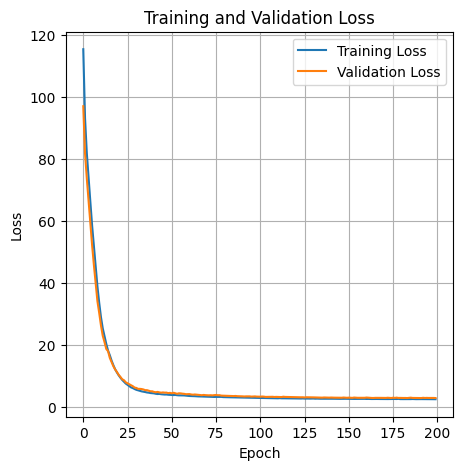

In [36]:
plot_train_loss(train_loss, test_loss)

In [37]:
def get_hand_info(hands: list):
    def get_hand_type(hand):
        if hand[0] == hand[1]:
            return 2 # pair
        elif hand[2] == 's':
            return 1 # suited
        else:
            return 0 # offsuit

    card_to_rank_id = {card: i for i, card in RANKS_DICT.items()}
    hand_info = []
    for hand in hands:
        card1, card2, suited = hand
        card1_rank_id = card_to_rank_id[card1]
        card2_rank_id = card_to_rank_id[card2]
        hand_type_id = get_hand_type(hand)
        hand_info.append((card1_rank_id, card2_rank_id, hand_type_id))
    return torch.tensor(hand_info)

In [38]:
def get_conditions(hands, position, players):
    positions = ['SB', 'BB', 'pos3', 'pos4', 'pos5', 'pos6', 'pos7', 'pos8', 'pos9','D']
    position_mapping = {pos: i for i, pos in enumerate(positions)}
    hand_info = get_hand_info(hands)
    card1_rank_id = hand_info[:, 0]
    card2_rank_id = hand_info[:, 1]
    hand_type_id = hand_info[:, 2]

    position_id = position_mapping[position]
    pos_ids = torch.tensor([position_id] * len(hands))
    play_ids = torch.tensor([players-2] * len(hands))
    return card1_rank_id, card2_rank_id, hand_type_id, pos_ids, play_ids


In [39]:
def sample_embeddings(model, hands, position, players):
    card1_rank, card2_rank, hand_type, position_ids, play_ids = get_conditions(hands, position, players)
    c = create_condition_vector(
        card1_rank,
        card2_rank,
        hand_type,
        position_ids,
        play_ids)
    sample = torch.randn(len(hands), model.mean_fc.out_features)
    data = torch.cat((sample, c), dim=1)
    model.to("cpu")
    model.eval()
    with torch.no_grad():
        gen_data = model.decoder(data)
    return gen_data.numpy()

In [40]:
def gen_ev_row(row):
    hand = [row['hand']]
    position = row['position']
    players = row['players']
    return sample_embeddings(model, hand, position, players)[0][0].item()


In [41]:
ev_data['vae_pred_ev'] = ev_data.apply(gen_ev_row, axis=1)

In [63]:
ev_data[['hand','EV','vae_pred_ev']].sort_values(by='EV', ascending=False)

,hand,EV,vae_pred_ev
1521,AAo,2.96,2.772922
1352,AAo,2.89,2.779690
8957,AAo,2.81,2.770514
169,AAo,2.81,2.570999
1014,AAo,2.79,2.719023
...,...,...,...
7899,92o,-0.42,-0.369636
290,94o,-0.42,-0.382974
280,T2o,-0.42,-0.362343
262,J3o,-0.42,-0.385389


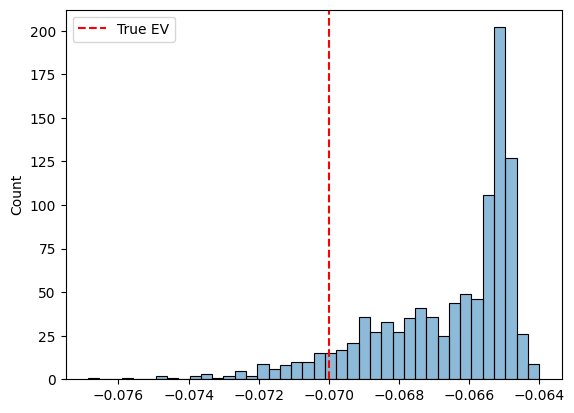

In [62]:
num_samples = 1000
hand = ['Q3s']
position = 'pos7'
players = 10
embeddings = sample_embeddings(model, hand*num_samples, position, players)

sns.histplot(embeddings, bins=40)
true_ev = ev_data[(ev_data.hand == hand[0]) & (ev_data.position == position) & (ev_data.players == players)]['EV'].iloc[0]
plt.axvline(x=true_ev, color='red', linestyle='--', label='True EV')
plt.legend()
plt.show()